# SE-PINN

This is a Jupyter Notebook in which a physics-informed neural network (PINN) is implemented with Python and PyTorch and used to solve the Schrodinger equation of quantum mechanics.

This has five parts, the first four of which are preparatory and the last of which is where the PINN is used.

### Integration of Physical Constraints

#### Normality

Because of the probabilistic interpretation of the wavefunction, its modulus is equal to 1.

Computationally, this contributes to comparability of runs.

#### Orthogonality

The set of all energy eigenstates is a basis, so they are all orthogonal to each other.

#### Symmetry

Here we define a custom architectural layer to enforce even symmetry or odd symmetry.

This is due to the mathematical fact that every function can be expressed as the sum of an even function and an odd function.

#### Information from the SE Itself

Last, we steer the model toward physical solutions by comparing its predictions in the Schrodinger equation itself and including the distance in the objective function.

## Preparation (1 / 5)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science','grid'])
from scipy.linalg import eigh_tridiagonal, eigvalsh_tridiagonal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# gif creation imports
# import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# this is just a shortcut to plot pytorch tensors (they need to be in numpy form for matplotlib)
def to_plot(x): return x.detach().cpu().numpy()

torch.cuda.init()
torch.cuda.is_initialized()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#if device == "cuda":
#    torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = "cpu" # had issues using gpu, restricted to cpu for convienience

torch.manual_seed(0) # Specify the random seed for reproducibility.

## Definition of PINN (2 / 5)

In [2]:
# NN class and hub layer class
class WFNN(nn.Module):
    def  __init__(self,grid_params, activation, sym = 0):
        super(WFNN, self).__init__()
        # "hyperparameters" describing gridpoints
        self.x0, self.xN, self.dx, self.N = grid_params
        self.activation = activation
        self.sym = sym
        
        # Defining network layers
        self.energy_node = nn.Linear(1,1)
        self.fc1_bypass = nn.Linear(1,50)
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)

        # Automatic detection of whether to enforce even symmetry or odd symmetry
        if sym == 1:
            self.output = HubLayer(50, 1, 1, 0)
        elif sym == -1:
            self.output = HubLayer(50, 1, 0, 1)
        else:
            self.output = nn.Linear(50,1)

    def swap_symmetry(self):
        if self.sym == 0:
            print('Tried to flip symmetry when none embedded!')
            return
        self.output.flip_sym()

    def forward(self, x):
        # lambda layer
        energy = self.energy_node(torch.ones_like(x))

        # Concatenating and feeding to network
        N = torch.cat((x,energy),1)
        N = self.activation(self.fc1(N))
        #N = self.activation(self.fc1_bypass(x))
        N = self.activation(self.fc2(N))
        N = self.output(N) # where symmetrization occurs if embedded

        wf = N
        return wf, energy

# The Hub Layer is used to enforce even symmetry (symmetry about the y-axis) or odd symmetry (symmetry about y = x).

# Adapted from https://auro-227.medium.com/writing-a-custom-layer-in-pytorch-14ab6ac94b77
class HubLayer(nn.Module):
    def __init__(self, size_in, size_out, even, odd):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out

        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        self.even = even
        self.odd = odd

        # Initialization of Weights
        nn.init.kaiming_uniform_(self.weights, a=np.sqrt(5))

        # Initialization of Biases
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

    def flip_sym(self):
        self.even = 1 - self.even
        self.odd = 1 - self.odd
        return

    def forward(self, x):
        h_plus = x # x(t)
        h_minus = torch.flip(x, [0]) # x(-t)
        H_plus = h_plus + h_minus
        H_minus = h_plus - h_minus

        N = (self.even * (1/2) * torch.mm(H_plus, self.weights.t())) + (self.odd * (1/2) * torch.mm(H_minus, self.weights.t()))

        return N

## Definition of Wrapped PINN (3 / 5)

In [3]:
# object to store runs
class WrappedPINN():
    def __init__(self, grid_params, activation, potential, sym):
        self.x0, self.xN, self.dx, self.N = grid_params

        self.x = torch.linspace(self.x0, self.xN, self.N-1).view(-1,1)
        self.V = potential
        
        self.model = WFNN(grid_params, activation, sym)
        self.model.to(device)

        # saving basis information
        self.basis = []
        self.basis_sum = torch.zeros_like(self.x)

        # current output / state of the model saved
        self.cur_loss = 0
        self.cur_energy = 0
        self.cur_wf = 0

        # lists to view history of the model, for plots
        self.losses = []
        self.energies = []
        self.wfs = []

    def init_optimizer(self, optim, lr = 1e-2):
        if optim == "LBFGS":
            self.opt = torch.optim.LBFGS(self.model.parameters(), lr=lr)
        elif optim == "Adam":
            self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        else:
            print("Invalid Optimizer")
        self.opt_name = optim

    def change_lr(self,lr):
        self.opt.param_groups[0]['lr'] = lr

    def swap_symmetry(self):
        self.model.swap_symmetry()

    def add_to_basis(self, base=None):
        if base is None:
            base = self.cur_wf.clone().detach()
        self.basis.append(base)
        self.basis_sum += base

    def closure(self):
        self.opt.zero_grad()
        l = self.loss(self.x)
        l.backward()
        return l
    
    def loss(self, x):
        self.x.requires_grad = True
        wf,energy = self.model(self.x)

        Orth_loss = (torch.sum(wf*self.basis_sum)*self.dx)**2

        d = torch.autograd.grad(wf.sum(), x, create_graph=True)[0]
        dd = torch.autograd.grad(d.sum(), x, create_graph=True)[0] # 2nd derivative
        SE_loss = torch.sum((-0.5*dd + self.V*wf - energy*wf)**2)/self.N

        NL_loss = (torch.sum(wf**2) - 1/self.dx)**2

        loss = SE_loss + NL_loss + Orth_loss + 0.5*(wf[0]**2 + wf[-1]**2) # boundary loss

        self.cur_wf, self.cur_energy, self.cur_loss = wf, energy[0].item(), loss.item() # saving state of NN for history

        return loss
    
    def train(self, epochs):
        for i in range(epochs):
            if self.opt_name == "LBFGS":
                loss = self.opt.step(self.closure)
                if loss.item() == torch.nan:
                    print("NAN loss")
                    break

            if self.opt_name == "Adam":
                self.opt.zero_grad()
                loss = self.loss(self.x)
                loss.backward()
                self.opt.step()
            
            self.wfs.append(self.cur_wf)
            self.energies.append(self.cur_energy)
            self.losses.append(self.cur_loss)

    def plot_loss(self):
        plt.plot(self.losses)
        plt.yscale('log')
        plt.title('Loss during Training')
        plt.show()

    def plot_energy(self):
        plt.plot(self.energies)
        plt.title('Predicted Energy Eigenvalue during Training')
        plt.show()

    def plot_wf(self, idx=None, ref=None):
        fig = plt.figure(figsize=(6,4))
        if idx is None:
            psi = self.cur_wf
        else:
            psi = self.wfs[idx]
        plt.plot(to_plot(self.x), to_plot(psi), 'r-', linewidth=2, label='Prediction')
        plt.plot(to_plot(self.x), -to_plot(psi), 'b-', linewidth=2, label='- Prediction')
        if ref is not None:
            plt.plot(to_plot(self.x), ref, 'k--', linewidth=2, label='Ground Truth')
        plt.title(f'Predicted Energy Eigenvector, E = {self.cur_energy:.2f}, norm = {torch.sum(psi**2)*self.dx:.2f}')
        plt.legend()
        plt.show()

    def create_gif(self, name, ref_wf=None, ref_ener=None, epoch_range=None):
        if epoch_range is None:
            epoch_range = 0, len(self.losses)
        num_frames = epoch_range[1] - epoch_range[0]

        fig, axes = plt.subplots(1,2, figsize=(12,4))
        def animate(i):
            idx = epoch_range[0] + i
            ax = axes[0]
            ax.clear()
            ax.plot(to_plot(self.x),  to_plot(self.wfs[idx]), 'r-', linewidth=2, label='Prediction')
            ax.plot(to_plot(self.x), -to_plot(self.wfs[idx]), 'b-', linewidth=2, label='-Prediction')
            if ref_wf is not None:
                ax.plot(to_plot(self.x), ref_wf,  'k--', linewidth=2, label='Ground Truth')
            ax.set_title(f'Epoch {i}: Energy = {self.energies[idx]:.2f}')
            ax.legend()
            ax.set_ylim([-1.5,1.5])

            ax = axes[1]
            ax.clear()
            ax.plot(np.arange(epoch_range[0],idx),self.energies[epoch_range[0]:idx])
            ax.set_xlim([epoch_range[0],epoch_range[1]])
            if ref_ener is not None:
                ax.axhline(ref_ener, linestyle="--", label="Ground Truth")
            ax.set_title('Energy')
            ax.legend()

        ani = FuncAnimation(fig,animate,frames=num_frames-1,interval=500)
        ani.save(name+".gif",dpi=100,writer=PillowWriter(fps=20))
        plt.close()

## Definition of Physical System (4 / 5)

In [4]:
# parameter and potential definitions
N = 500
x0, xN = -5., 5.
dx = (xN-x0)/N
grid_params = x0, xN, dx, N

# extra width for solver
x = torch.linspace(x0,xN,N+1).view(-1,1)
k = 100
V = 0.5*k*x**2

# calling eigenvalue solver
diagonal = 1/dx**2 + V[1:-1].detach().cpu().numpy()[:,0]
edge = -0.5/dx**2 * np.ones(diagonal.shape[0] - 1)
energies, eigenvectors = eigh_tridiagonal(diagonal, edge)

# standard normalization of eigenvectors
norms = dx*np.sum(eigenvectors**2, axis=0)
eigenvectors /= np.sqrt(norms) # sqrt to account for L_2 normalization of wf

# creating references to convinient gnd state objects
gnd_state = eigenvectors.T[0]
gnd_energy = energies[0]

x = torch.linspace(x0,xN,N-1).view(-1,1) #back to normal width
k = 100
V = 0.5*k*x**2

## Use of Wrapped PINN (5 / 5)

In [5]:
# first, we initialize the network with our hyperparameters
wrapped_pinn = WrappedPINN(grid_params, torch.tanh, V, sym = 0)

# then initialize optimizer, Adam or LBFGS, with learning rate
wrapped_pinn.init_optimizer("LBFGS",lr=1e-3)

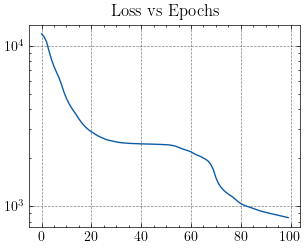

In [6]:
# Can start by training for a number of epochs, and plotting the loss
wrapped_pinn.train(100)

wrapped_pinn.plot_loss()

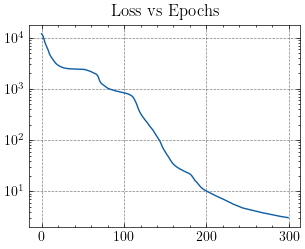

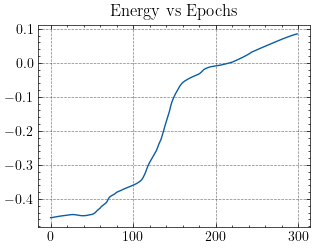

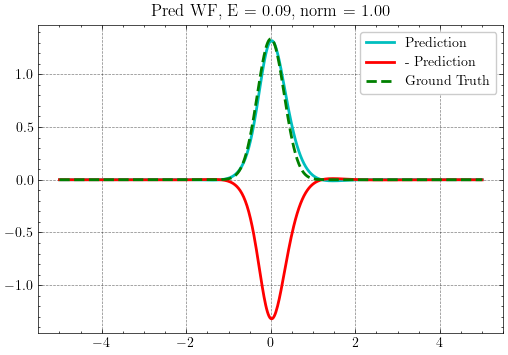

In [7]:
# looks good so far, we can train for more consecutive epochs
wrapped_pinn.train(200)

# these plot functions below can also take a specficed epoch range for plotting
wrapped_pinn.plot_loss()
wrapped_pinn.plot_energy()
wrapped_pinn.plot_wf(ref=gnd_state) # specify a wavefunction for comparison

In [ ]:
# Some additional options:
wrapped_pinn.swap_symmetry() # if even --> odd and vice versa

wrapped_pinn.add_to_basis() # adds current wavefunction to basis

wrapped_pinn.add_to_basis(gnd_state) # adds passed wf to basis

# Can also make a gif, showing the evolution of the wavefunction
wrapped_pinn.create_gif("movie", ref_ener=energies[0], ref_wf=gnd_state)